# Reactive GRASP

In reactive GRASP the probability of selecting a RCL size is proportional to historical performance of this RCL size.  Here GRASP **learns** the bias of RCL sizes needed to get the best results.

Let $q_i = f^* / A_i$
and $p_i = \dfrac{q_i}{\sum_{j=1}^{m} q_j}$
        
where

$f^*$ is the incumbent (best cost); 
$A_i$ is the mean cost found with $r_i$

larger $q_i$ indicates more suitable values of $r_i$



## Imports

In [1]:
import numpy as np

## `metapy` imports

In [2]:
# uncomment if running in Google Colab
# pip install meta-py==0.2.1

In [3]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber, TweakTwoOpt)

from metapy.tsp.grasp import (SemiGreedyConstructor, GRASP)

## Load problem

In [4]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Implementation

To implement we create two new classes:

* `MonitoredLocalSearch` - wraps HillClimber and notifies observering classes when a GRASP local search phase is complete.
* `ReactiveRCLSizer` - observes GRASP local search, tracks average performance of RCL sizes, and updates prob of choosing different r's at a user specified frequency:


In [5]:
class MonitoredLocalSearch:
    '''
    Extends a local search class and provides the observer pattern.
    An external object can observe the local search object and catch the
    termination event (end of local search).  The observer is notified and
    passed the results of the local search.

    Use cases: 
    ----------
    In GRASP this is useful for an algorithm sizing the RCL and learning 
    on average how different sizes of RCL perform.
    '''
    def __init__(self, local_search):
        '''
        Constructor:
        
        Params:
        ------
        local_search: Object
            Must implement .solve(), best_cost, best_solution
        '''
        self.local_search = local_search
        self.observers = []
    
    def register_observer(self, observer):
        '''
        register an object to observe the local search
        
        The observer should implement 
        local_search_terminated(*args, **kwargs)
        '''
        self.observers.append(observer)
        
    def set_init_solution(self, solution):
        '''
        Set the initial solution
        
        Params:
        --------
        solution: np.ndarray
            vector representing the initial solution
        '''
        self.local_search.set_init_solution(solution)
    
    def solve(self):
        '''
        Run the local search.  
        At the end of the run all observers are notified.
        '''    
        # run local search
        self.local_search.solve()
        
        # notify observers after search terminates.
        best = self.local_search.best_cost
        solution = self.local_search.best_solutions[0]
        self.notify_observers(best, solution)
        
    
    def notify_observers(self, *args, **kwargs):
        '''
        Observers must implement `local_search_terminated()`
        method.
        
        Params:
        ------
        *args: list
            variable number of arguments
            
        **kwargs: dict
            key word arguments
        '''
        for o in self.observers:
            o.local_search_terminated(*args, **kwargs)
    
    def _get_best_cost(self):
        '''
        best cost from internal local_search object
        '''
        return self.local_search.best_cost
    
    def _get_best_solutions(self):
        '''
        get best solutions from local_search object
        '''
        return self.local_search.best_solutions
    
    best_cost = property(_get_best_cost, doc='best cost')
    best_solutions = property(_get_best_solutions, doc='best solution')

In [6]:
class ReactiveRCLSizer:
    '''
    Dynamically update the probability of selecting a 
    value of r for the size of the RCL.
    
    Implements Reactive GRASP.
    
    '''
    def __init__(self, r_list, local_search, freq=None, random_seed=None):
        '''
        Constructor
        
        Params:
        -------
        r_list: list
            vector of sizes for RCL e.g. [1, 2, 3, 4, 5]
            
        local_search: MonitoredLocalSearch
            local_search to monitor
            
        freq: int, optional (default=None)
            Frequency in iterations at which the probabilities are updated.
            When set to None it defaults to the length of r_list * 2
            
        random_seed: int, optional (default=None)
            Control random sampling for reproducible result
        '''
        # list of r sizes
        self.r_list = r_list
        
        # set of indexes to work with probabilities
        self.elements = np.arange(len(r_list))
    
        # probability of choosing r (initially uniform)
        self.probs = np.full(len(r_list), 1/len(r_list))
        
        # mean performance of size r
        self.means = np.full(len(r_list), 1.0)
        
        # runs of size r
        self.allocations = np.full(len(r_list), 0)
        
        # local search to monitor
        self.local_search = local_search
        
        # frequency of updating probs
        if freq is None:
            self.freq = len(self.r_list)
        else:
            self.freq = freq
        
        # number of iterations within frequency
        self.iter = 0
        
        # current r index
        self.index = -1
        
        # to init run one of each r value
        self.init = True
        
        # imcumbent solution cost
        self.best_cost = -np.inf
        
        # register sizer as observer of the local search
        local_search.register_observer(self)
        
        # random no. gen
        self.rng = np.random.default_rng(random_seed)
    
    def local_search_terminated(self, *args, **kwargs):
        '''
        Termination of the local search
        '''
        # iteration complete
        self.iter += 1
        
        # get the best cost found in the iteration
        iter_cost = args[0]

        # record iteration took plaxe with index i
        self.allocations[self.index] += 1
        
        # update running mean
        mean_x = self.means[self.index]
        n = self.allocations[self.index]
        self.means[self.index] += (iter_cost - mean_x) / n
        
        self.update_r()
        
        # update incumbent cost if required
        if iter_cost > self.best_cost:
            self.best_cost = iter_cost
        
        # update probs if freq met.
        if self.iter >= self.freq and not self.init:
            self.iter = 0
            self.update_probability()
            
        
    def update_probability(self):
        '''
        Let $q_i = f^* / A_i$
        and $p_i = `\dfrac{q_i}{\sum_{j=1}^{m} q_j}$
        
        where
        
        $f^*$ is the incumbent (cost)
        $A_i$ is the mean cost found with r_i
        
        larger q_i indicates more suitable values of r_i
        '''
        q = self.best_cost / self.means
        self.probs = q / q.sum()
    
    def update_r(self):
        '''
        update the size of r
        
        Note that the implementation ensures that all r values are run
        for at least one iteration of the algorithm.
        '''
        # initial bit of logic makes sure there is at least one run of all probabilities
        if self.init:
            self.index += 1
            if self.index >= len(self.r_list):
                self.init = False
                self.index = self.rng.choice(self.elements, p=self.probs)
        else:
            self.index = self.rng.choice(self.elements, p=self.probs)
    
    def get_size(self):
        '''
        Return the selected size of the RCL
        
        The selection is done using a discrete distribution
        self.r_probs.
        '''
        return self.r_list[self.index]
       

## Running Reactive GRASP

In [7]:
def compose_grasp(tour, matrix, max_iter=50, freq=10, rcl_min=2, rcl_max=15, 
                  seeds=(None, None)):
    '''
    Compose the REACTIVE GRASP algorithm    
    '''
    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = MonitoredLocalSearch(HillClimber(obj, tour, tweaker))

    # semi-greedy constructor and RCL sizer
    sizer = ReactiveRCLSizer(np.arange(rcl_min, rcl_max), ls, freq=freq, 
                             random_seed=seeds[0])
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=seeds[1])

    # GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running REACTIVE GRASP

** GRASP OUTPUT ***
best cost:	-738.0
best solutions:
[ 0 35 22 12 28 69 34 56 14 23  1 18 54 48 25  7 27  2 31  6  3 17 41  5
 40 43 13 19 29 67 26 45 24 44 38 60 39  8 42 16 20 33 11 59 32 61 53 47
 66 10 63 64 55 50 51  9  4 52 65 62 21 58 68 30 37 46 36 49 57 15]


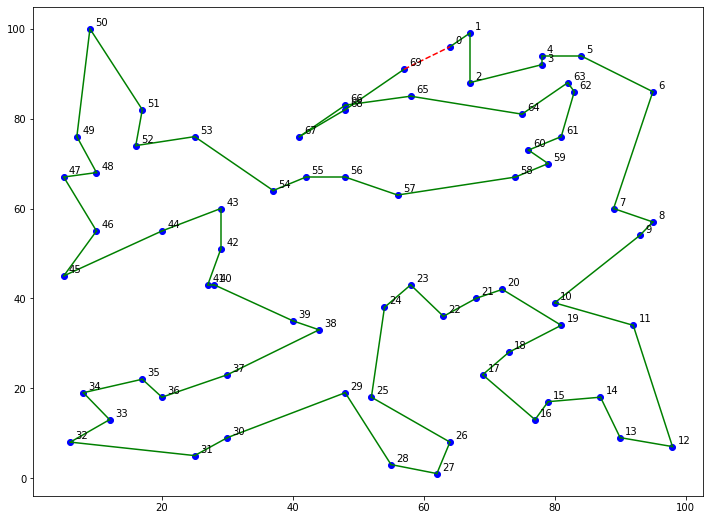

In [9]:
tour = np.arange(len(cities))
solver = compose_grasp(tour, matrix, seeds=(42, 101))
print("\nRunning REACTIVE GRASP")
solver.solve()

print("\n** GRASP OUTPUT ***")
print(f"best cost:\t{solver.best}")
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))